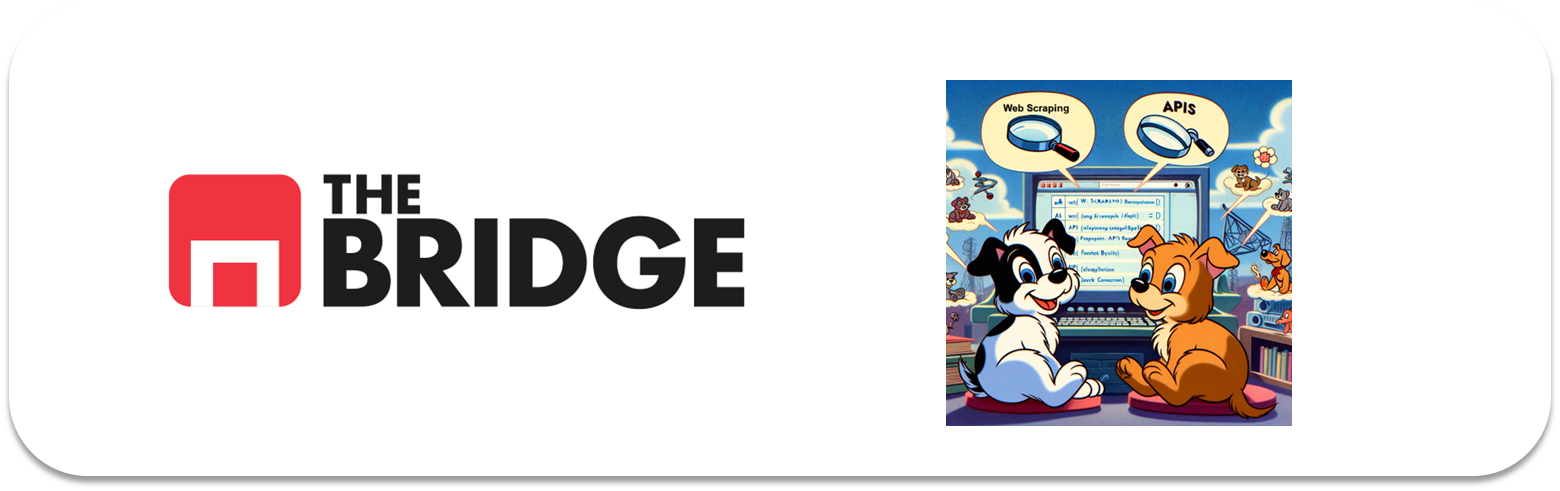

# Web Scraping en Python: Ejemplo práctico (II)

Pues no perdamos tiempo, carguemos la página de "El País" que estábamos analizando y recordemos objetivo y el resultado de nuestra inspección a través del navegador

In [1]:
import pandas as pd
import requests

from bs4 import BeautifulSoup

url = "https://static.elpais.com/hemeroteca/elpais/2023/04/24/m/portada.html"
elpais = requests.get(url) # Obtenemos la página dentro de un objeto Request

soup_elpais = BeautifulSoup(elpais.text, "lxml") # Parseamos el documento HTML de la página

+ **Objetivo**: Obtener las noticias por sección y con su fecha.
+ **Pesquisas**: Tenemos la infor en las etiquetas: time, section y article. Tenemos que hacer un pequeño tratamiento.

Ahora podemos pintarnos toda la página con el método `prettify` e intentar hacer el mismo análisis, pero ejecuta la celda siguiente y "déjate" los ojos 

In [3]:
print(soup_elpais.prettify())

<!DOCTYPE html>
<html lang="es-ES">
 <head>
  <link href="//static.elpais.com" rel="preconnect"/>
  <link href="//ep00.epimg.net" rel="preconnect"/>
  <link href="//imagenes.elpais.com" rel="preconnect"/>
  <link href="//www.googletagservices.com" rel="preconnect"/>
  <link href="//ping.chartbeat.net" rel="preconnect"/>
  <link href="//cdn.krxd.net" rel="preconnect"/>
  <link href="//assets.adobedtm.com" rel="preconnect"/>
  <link as="font" crossorigin="" href="https://static.elpais.com/dist/resources/fonts/majrit/majrit-text/Majrit-Text-Bold.woff2" rel="preload" type="font/woff2"/>
  <link as="font" crossorigin="" href="https://static.elpais.com/dist/resources/fonts/majrit/majrit-text/Majrit-Text-Roman.woff2" rel="preload" type="font/woff2"/>
  <link as="font" crossorigin="" href="https://static.elpais.com/dist/resources/fonts/marcin-ant-b/marcinantb-regular-webfont.woff2" rel="preload" type="font/woff2"/>
  <link as="font" crossorigin="" href="https://static.elpais.com/dist/resources

### Extración de la fecha: Tag -> time

Sabemos que la fecha está en un Tag "time", pero vimos que había varios, tenemos que asegurarnos que es el Tag "time" que cuelga de otro Tag con atributo "data-dtm-region" igual a "portada_menu". Entonces tenemos que escribirnos un código que nos capture precisamente ese Tag time:

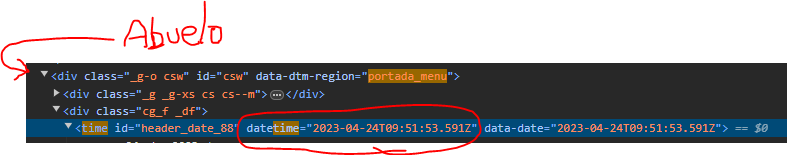

In [6]:
# Iremos recuperando todos los Tags de tipo "time" y para cada uno recorreremos el árbol de sus padres con el método
# correspondiente, cuando encontremos el que tenga el atributo indicado, nos quedaremos con el Tag "time" que 
# estábamos revisando y pararemos

fin = False     # Flag para salirnos del for
for tiempo in soup_elpais.find_all('time'):
    for padre in tiempo.parents:
        if padre.attrs.get('data-dtm-region', None) == 'portada_menu':    # Aprovechamos el método get de los diccionarios
            print(tiempo)
            tiempo_tag = tiempo
            fin = True
            break
    if fin:
        break



<time data-date="2023-04-24T09:51:53.591Z" datetime="2023-04-24T09:51:53.591Z" id="header_date_88"><span>24 abr 2023</span><span class="x_e_s">|</span><span>Actualizado<!-- --> <!-- -->09:51<!-- --> <abbr title="UTC">UTC</abbr></span><span class="x_e_s">|</span></time>


¿Y que valor me quedo? Veamos los atributos, string y text:

In [8]:
print('Atributos: ', tiempo.attrs) # Me voy a quedar con el datetime porque pandas lo podrá transformar directamente
print('Strings: ', tiempo.string)
print('Text: ', tiempo.text)

Atributos:  {'id': 'header_date_88', 'datetime': '2023-04-24T09:51:53.591Z', 'data-date': '2023-04-24T09:51:53.591Z'}
Strings:  None
Text:  24 abr 2023|Actualizado 09:51 UTC|


Podemos escoger el que queramos, vamos a quedarnos el datetime porque luego le diremos a Pandas que lo use como tal:

In [11]:
fecha = tiempo_tag['datetime']
fecha

'2023-04-24T09:51:53.591Z'

### Extracción de los artículos y las secciones: Tags -> section y article

Tenemos el tiempo es el momento de capturar los artículos y sus secciones. Recordaras ,y si no, te lo recuerdo yo, que teniamos Tag "section" y dentro de estos colgaban Tag "articles". El nombre de la seccion estaba en el atributo "data-dtm-region".

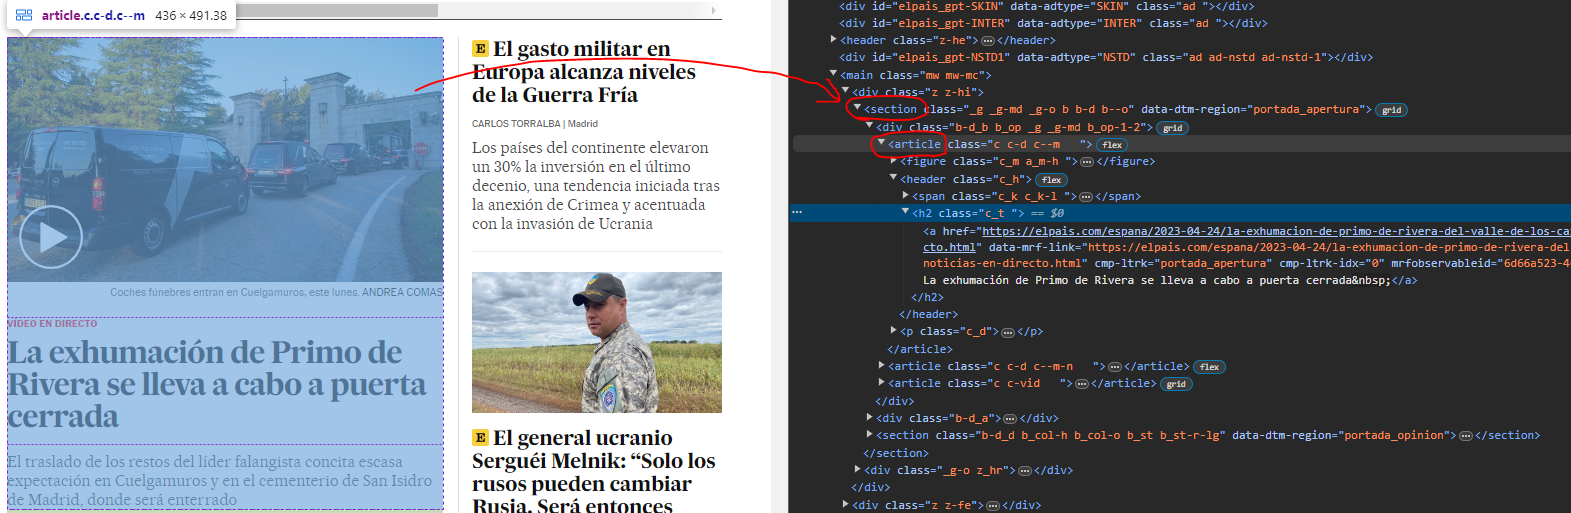

In [12]:
# Recorramos todos los Tags tipo "section", capturemos su atributo "data-dtm-regioin" y luego para cada "section" vayamos acumulando sus artículos
for seccion in soup_elpais.find_all('section'):
    nombre_seccion = seccion.get('data-dtm-region', 'Otros')
    for articulo in seccion.find_all('article'):
        noticia = articulo.header.get_text(separator = ':')
        if noticia:
            print(f'He encontrado una noticia de la sección {nombre_seccion}:')
            print(f'NOTICIA --> {noticia}')
            print('\n'*2)

He encontrado una noticia de la sección portada_apertura:
NOTICIA --> vídeo en directo:La exhumación de Primo de Rivera se lleva a cabo a puerta cerrada 



He encontrado una noticia de la sección portada_apertura:
NOTICIA --> El Gobierno ejecuta el traslado de los restos del fundador de la Falange tras los de Franco, Queipo, Sanjurjo y Mola



He encontrado una noticia de la sección portada_apertura:
NOTICIA --> Vídeo | Así ‘sacralizó’ el franquismo al líder falangista:Samuel Martínez



He encontrado una noticia de la sección portada_apertura:
NOTICIA --> El gasto militar en Europa alcanza niveles de la Guerra Fría



He encontrado una noticia de la sección portada_apertura:
NOTICIA --> El general ucranio Serguéi Melnik: “Solo los rusos pueden cambiar Rusia. Será entonces cuando termine la guerra”



He encontrado una noticia de la sección portada_apertura:
NOTICIA --> EDITORIAL:Pulso agrícola en la UE 



He encontrado una noticia de la sección portada_apertura:
NOTICIA --> Una mora

Bien, parece que lo tenemos, aunque quizá podríamos ser más percisos y quitarnos tanto texto, pero eso te lo dejo a ti (Ahora ya no tendrías que ir a la página web con el navegador, podrías inspeccionar las noticias con demasiado texto directamente sobre el HTML y buscar la forma de reducir el texto)

### Juntándolo todo en un `DataFrame`



Ahora reusamos el código anterior, más la fecha, para crear una lista de diccionarios que luego nos servirá para generar el `DataFrame`

In [13]:
# Creamos nuestra lista de diccionarios, uno por noticia. Reutilizando el código
lista_noticias = []
for seccion in soup_elpais.find_all('section'):
    nombre_seccion = seccion.get('data-dtm-region', 'Otros')
    for articulo in seccion.find_all('article'):
        noticia = articulo.header.get_text(separator = ':')
        if noticia:
            lista_noticias.append({'fecha': fecha, 'noticia': noticia, 'sección': nombre_seccion}) # fecha es la de antes

In [14]:
df = pd.DataFrame(lista_noticias)
df

,fecha,noticia,sección
0,2023-04-24T09:51:53.591Z,vídeo en directo:La exhumación de Primo de Riv...,portada_apertura
1,2023-04-24T09:51:53.591Z,El Gobierno ejecuta el traslado de los restos ...,portada_apertura
2,2023-04-24T09:51:53.591Z,Vídeo | Así ‘sacralizó’ el franquismo al líder...,portada_apertura
3,2023-04-24T09:51:53.591Z,El gasto militar en Europa alcanza niveles de ...,portada_apertura
4,2023-04-24T09:51:53.591Z,El general ucranio Serguéi Melnik: “Solo los r...,portada_apertura
...,...,...,...
130,2023-04-24T09:51:53.591Z,Un médico triunfa al contar el comentario que ...,Otros
131,2023-04-24T09:51:53.591Z,Asensio depende de Brahim,Otros
132,2023-04-24T09:51:53.591Z,Del café a la cocaína en el trabajo: la otra c...,Otros
133,2023-04-24T09:51:53.591Z,Las 10 mejores películas y series de mafia de ...,Otros


Para terminar convertimos el campo "fecha" en `datetime` [aunque aquí parece poco útil, lo será si repetimos esta operación todos los días o con toda la hemeroteca], y guardamos nuestro `DataFrame` [Nota: si sientes curiosidad el formato de fecha que usa "El País" es el denominado `ISO-8601`]

In [15]:
df['fecha'] = pd.to_datetime(df['fecha'])
df

,fecha,noticia,sección
0,2023-04-24 09:51:53.591000+00:00,vídeo en directo:La exhumación de Primo de Riv...,portada_apertura
1,2023-04-24 09:51:53.591000+00:00,El Gobierno ejecuta el traslado de los restos ...,portada_apertura
2,2023-04-24 09:51:53.591000+00:00,Vídeo | Así ‘sacralizó’ el franquismo al líder...,portada_apertura
3,2023-04-24 09:51:53.591000+00:00,El gasto militar en Europa alcanza niveles de ...,portada_apertura
4,2023-04-24 09:51:53.591000+00:00,El general ucranio Serguéi Melnik: “Solo los r...,portada_apertura
...,...,...,...
130,2023-04-24 09:51:53.591000+00:00,Un médico triunfa al contar el comentario que ...,Otros
131,2023-04-24 09:51:53.591000+00:00,Asensio depende de Brahim,Otros
132,2023-04-24 09:51:53.591000+00:00,Del café a la cocaína en el trabajo: la otra c...,Otros
133,2023-04-24 09:51:53.591000+00:00,Las 10 mejores películas y series de mafia de ...,Otros
